# Titanic

In [44]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import catboost
import optuna

import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.utils.class_weight import compute_class_weight

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, \
                            cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, \
                            make_scorer, roc_auc_score, auc, roc_curve, precision_score, recall_score, f1_score, \
                            balanced_accuracy_score

from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import make_scorer
import random

# Фиксация всех seed
np.random.seed(42)
random.seed(42)
RANDOM_STATE = 42

### Загрузка и ознакомление

In [45]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [46]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [47]:
train.info(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [48]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [49]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [50]:
train['Cabin'] = train['Cabin'].fillna('Unknown')
train['Age'] = train.groupby('Sex')['Age'].transform(lambda x: x.fillna(x.median()))
train['Embarked'] = train['Embarked'].fillna('Unknown')


In [51]:
train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [52]:
train.duplicated().sum()

np.int64(0)

In [53]:
test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [54]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [55]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [56]:
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [57]:
test['Cabin'] = test['Cabin'].fillna('Unknown')
test['Age'] = test.groupby('Sex')['Age'].transform(lambda x: x.fillna(x.median()))
test['Fare'] = test['Fare'].fillna(test['Fare'].median())

In [58]:
test.isna().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [59]:
test.duplicated().sum()

np.int64(0)

In [60]:
# Объединим train и test
test['Survived'] = -1

df = pd.concat([train, test], ignore_index=True)
df.shape


(1309, 12)

### EDA

Survived
 0    549
-1    418
 1    342
Name: count, dtype: int64

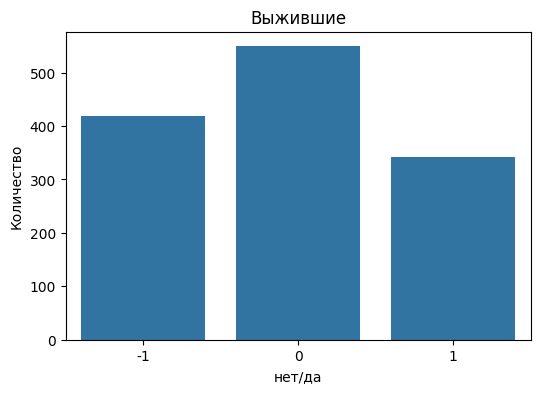

In [61]:
display(df['Survived'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(df, x='Survived')
plt.title('Выжившие')
plt.xlabel('нет/да')
plt.ylabel('Количество')
plt.show()


Дисбаланс в целевой переменной


Pclass
3    709
1    323
2    277
Name: count, dtype: int64

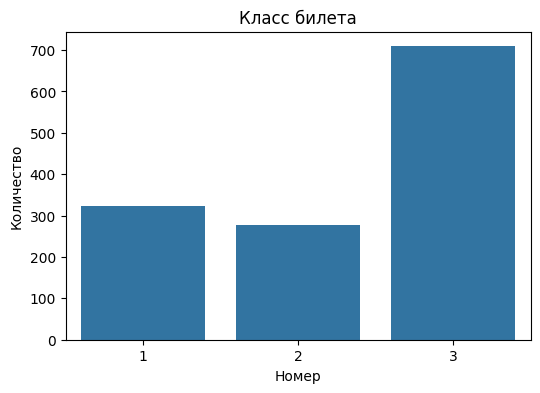

In [62]:
display(df['Pclass'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(df, x='Pclass')
plt.title('Класс билета')
plt.xlabel('Номер')
plt.ylabel('Количество')
plt.show()

Sex
male      843
female    466
Name: count, dtype: int64

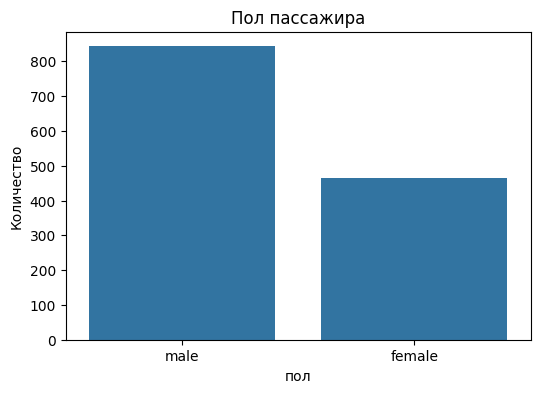

In [63]:
display(df['Sex'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(df, x='Sex')
plt.title('Пол пассажира')
plt.xlabel('пол')
plt.ylabel('Количество')
plt.show()

Мужчин почти в 2 раза больше, чем женщин

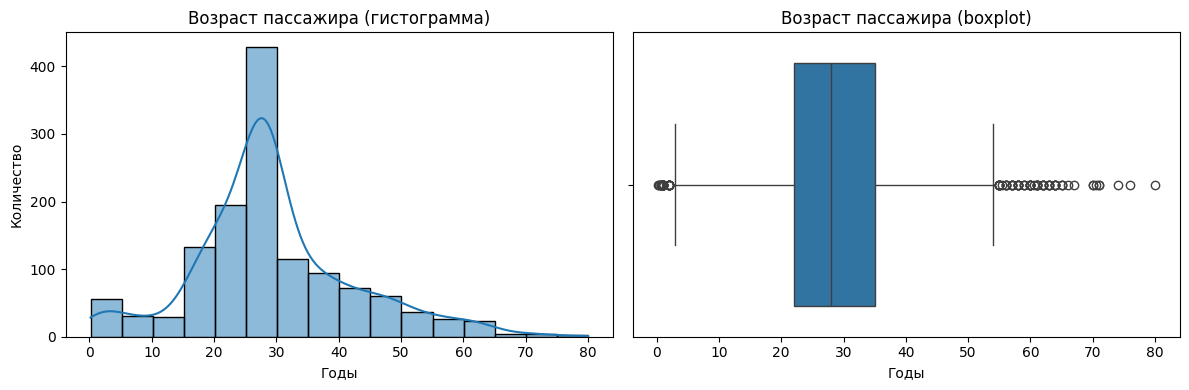

In [64]:
# Создаем один figure с двумя графиками (в ряд)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))  # Общий размер всего изображения

# Гистограмма + KDE
sns.histplot(df, x='Age', bins=16, kde=True, ax=ax[0])
ax[0].set_title('Возраст пассажира (гистограмма)')
ax[0].set_xlabel('Годы')
ax[0].set_ylabel('Количество')

# Boxplot
sns.boxplot(df, x='Age', ax=ax[1])
ax[1].set_title('Возраст пассажира (boxplot)')
ax[1].set_xlabel('Годы')

# Чтобы графики не накладывались друг на друга
plt.tight_layout()
plt.show()

Средний возраст около 30 лет

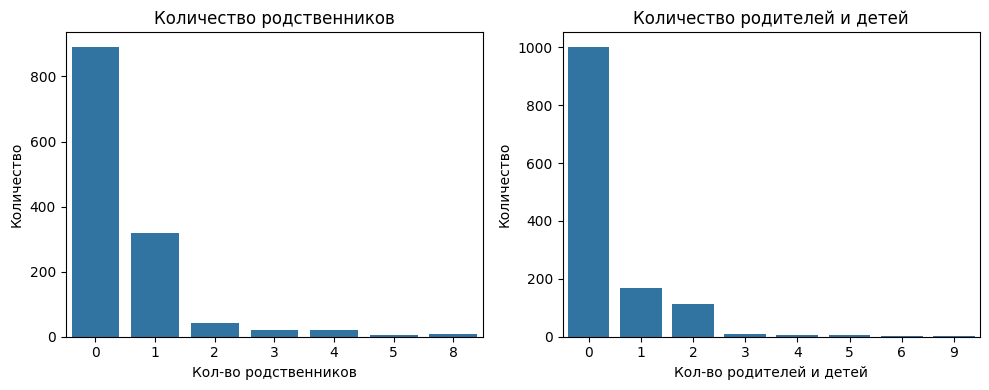

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

sns.countplot(df, x='SibSp', ax=ax[0])
ax[0].set_title('Количество родственников')
ax[0].set_xlabel('Кол-во родственников')
ax[0].set_ylabel('Количество')

sns.countplot(df, x='Parch', ax=ax[1])
ax[1].set_title('Количество родителей и детей')
ax[1].set_xlabel('Кол-во родителей и детей')
ax[1].set_ylabel('Количество')

plt.tight_layout()
plt.show()

У большинства пассажиров нет родственников.

Большинство пассажиров без семей.

Embarked
S          914
C          270
Q          123
Unknown      2
Name: count, dtype: int64

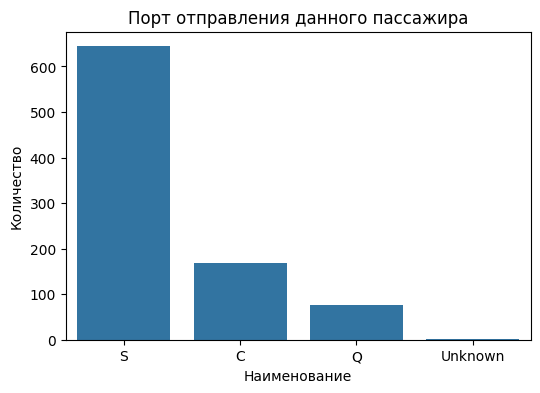

In [66]:
display(df['Embarked'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(train, x='Embarked')
plt.title('Порт отправления данного пассажира')
plt.xlabel('Наименование')
plt.ylabel('Количество')
plt.show()

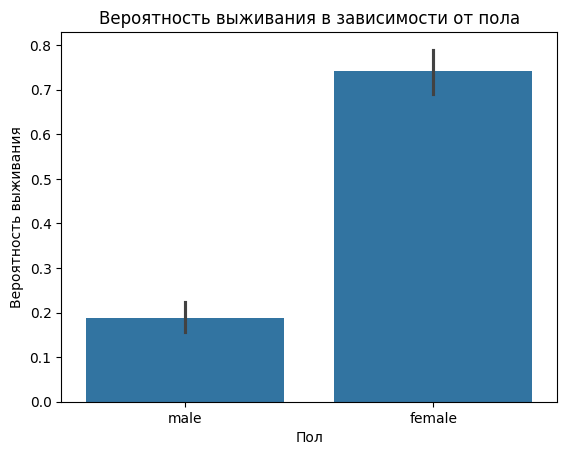

In [67]:
train.groupby('Sex')['Survived'].mean()
sns.barplot(train, x='Sex', y='Survived')
plt.title('Вероятность выживания в зависимости от пола')
plt.xlabel('Пол')
plt.ylabel('Вероятность выживания')

plt.show()

Большинство выживших женщины

### Feature Engineering

In [68]:
# Извлечение титула
df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

# Группировка редких титулов
rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
df['Title'] = df['Title'].replace(rare_titles, 'Rare')
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

# Кодирование титулов
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
df['Title'] = df['Title'].map(title_mapping).fillna(0)

# Размер семьи
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# Тариф на человека
df['FarePerPerson'] = df['Fare'] / df['FamilySize']

# Дети
df['IsChild'] = (df['Age'] < 18).astype(int)

# Возрастные группы
df['AgeGroup'] = pd.cut(df['Age'], 
                        bins=[0, 12, 18, 30, 50, 100], 
                        labels=['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior'])

# Пол + Класс
df['Sex_Pclass'] = df['Sex'] + '_' + df['Pclass'].astype(str)

# Возраст * Класс
df['Age_Pclass'] = df['Age'] * df['Pclass']

# Тариф * Класс
df['Fare_Pclass'] = df['Fare'] * df['Pclass']

# Редкие семейные ситуации
df['SingleParent'] = ((df['Parch'] > 0) & (df['SibSp'] == 0)).astype(int)


In [69]:

columns_to_drop = [
    'Name', 'Ticket', 'Cabin', 'Sex',
    'SibSp', 'Parch', 'Fare', 'Age', 'Pclass'
]
df = df.drop(columns=columns_to_drop)

### Корреляция

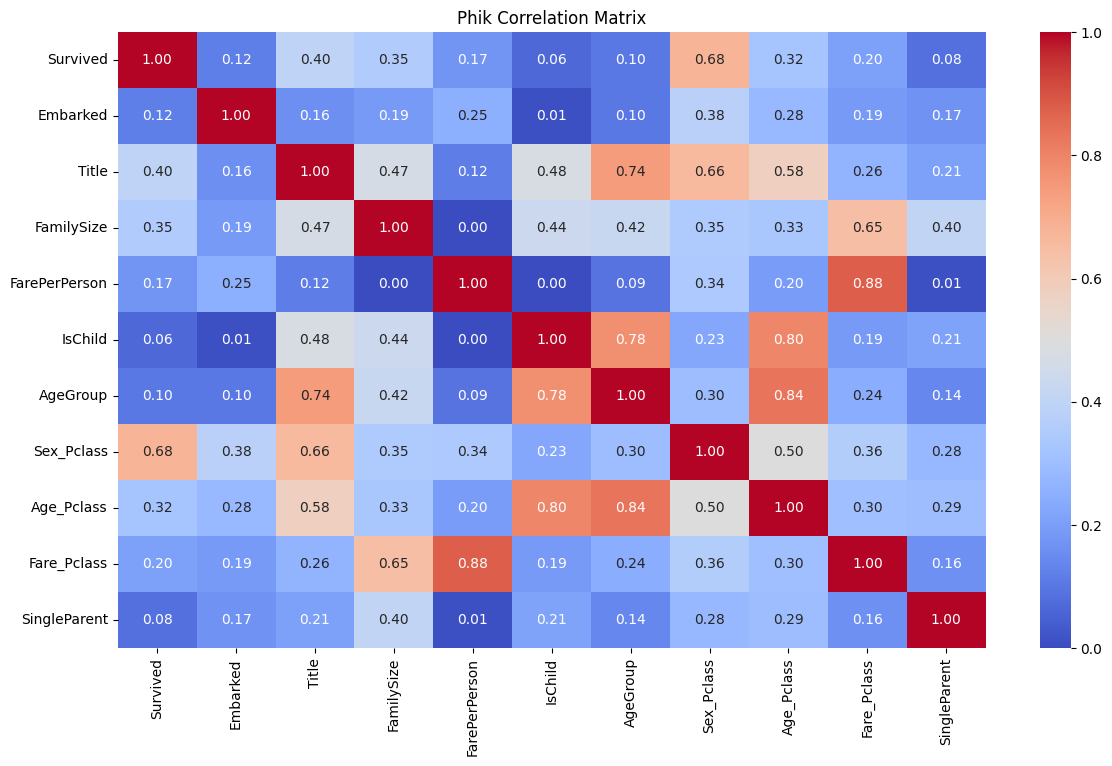

In [70]:
phik_matrix = df.drop(columns=['PassengerId']).phik_matrix(interval_cols=['FarePerPerson', 'FamilySize', 'Age_Pclass','Fare_Pclass'])

plt.figure(figsize=(14,8))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Phik Correlation Matrix")
plt.show()      

In [71]:
# Выбираем корреляцию каждого признака с целевой переменной
target_correlations = phik_matrix['Survived']

# Сортируем по убыванию (по абсолютному значению)
target_correlations = target_correlations.abs().sort_values(ascending=False)

# Выводим результат
print("Корреляция признаков с целевой переменной 'Survived':")
print(target_correlations)

Корреляция признаков с целевой переменной 'Survived':
Survived         1.000000
Sex_Pclass       0.678612
Title            0.397462
FamilySize       0.352783
Age_Pclass       0.321344
Fare_Pclass      0.203703
FarePerPerson    0.173665
Embarked         0.118933
AgeGroup         0.103985
SingleParent     0.082166
IsChild          0.063423
Name: Survived, dtype: float64


In [72]:
display(df.shape)
df.head(20)

(1309, 12)

,PassengerId,Survived,Embarked,Title,FamilySize,FarePerPerson,IsChild,AgeGroup,Sex_Pclass,Age_Pclass,Fare_Pclass,SingleParent
0,1,0,S,1,2,3.625000,0,YoungAdult,male_3,66.0,21.7500,0
1,2,1,C,3,2,35.641650,0,Adult,female_1,38.0,71.2833,0
2,3,1,S,2,1,7.925000,0,YoungAdult,female_3,78.0,23.7750,0
3,4,1,S,3,2,26.550000,0,Adult,female_1,35.0,53.1000,0
4,5,0,S,1,1,8.050000,0,Adult,male_3,105.0,24.1500,0
5,6,0,Q,1,1,8.458300,0,YoungAdult,male_3,87.0,25.3749,0
6,7,0,S,1,1,51.862500,0,Senior,male_1,54.0,51.8625,0
7,8,0,S,4,5,4.215000,1,Child,male_3,6.0,63.2250,0
8,9,1,S,3,3,3.711100,0,YoungAdult,female_3,81.0,33.3999,1
9,10,1,C,3,2,15.035400,1,Teen,female_2,28.0,60.1416,0


### Подготовка данных

In [73]:
train = df[df['Survived'] != -1]
test = df[df['Survived'] == -1].drop(columns=['Survived'])
print(f'train: {train.shape}, test: {test.shape}')

train: (891, 12), test: (418, 11)


#### Разбивка на трейн/тест

In [74]:
# 1. Подготовка данных
X = train.drop(columns=['Survived', 'PassengerId'])
y = train['Survived']


# # Разделение с учетом дисбаланса
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    stratify=y, 
    test_size=0.2, 
    random_state=42
)


print('Размерность выборки X_train: ', X_train.shape)
print('Размерность выборки X_val: ', X_val.shape)
print('Размерность выборки y_train: ', y_train.shape)
print('Размерность выборки y_val: ', y_val.shape)
display(X_train.head())
X_val.head()


Размерность выборки X_train:  (712, 10)
Размерность выборки X_val:  (179, 10)
Размерность выборки y_train:  (712,)
Размерность выборки y_val:  (179,)


,Embarked,Title,FamilySize,FarePerPerson,IsChild,AgeGroup,Sex_Pclass,Age_Pclass,Fare_Pclass,SingleParent
692,S,1,1,56.4958,0,YoungAdult,male_3,87.0,169.4874,0
481,S,1,1,0.0000,0,YoungAdult,male_2,58.0,0.0000,0
527,S,1,1,221.7792,0,YoungAdult,male_1,29.0,221.7792,0
855,S,3,2,4.6750,0,Teen,female_3,54.0,28.0500,1
801,S,3,3,8.7500,0,Adult,female_2,62.0,52.5000,0


,Embarked,Title,FamilySize,FarePerPerson,IsChild,AgeGroup,Sex_Pclass,Age_Pclass,Fare_Pclass,SingleParent
565,S,1,3,8.050000,0,YoungAdult,male_3,72.0,72.4500,0
160,S,1,2,8.050000,0,Adult,male_3,132.0,48.3000,1
553,C,1,1,7.225000,0,YoungAdult,male_3,66.0,21.6750,0
860,S,1,3,4.702767,0,Adult,male_3,123.0,42.3249,0
241,Q,2,2,7.750000,0,YoungAdult,female_3,81.0,46.5000,0


In [75]:
num_features = ['FarePerPerson', 'Age_Pclass', 'Fare_Pclass']
ordinal_features = ['FamilySize', 'AgeGroup']  
cat_features = ['Embarked', 'Title', 'IsChild', 'Sex_Pclass', 'SingleParent']

# Пайплайны обработки
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])


family_size_categories = [1, 2, 3, 4, 5, 6, 7, 8, 11]
age_group_categories = ['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior']
ordinal_transformer = Pipeline(steps=[('ordinal', OrdinalEncoder(categories=[family_size_categories, age_group_categories]))])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])


# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('ordinal', ordinal_transformer, ordinal_features),
        ('cat', categorical_transformer, cat_features),
        ],
    remainder='passthrough'
)

In [76]:
# Применение препроцессора к train и test
X_train_processed = preprocessor.fit_transform(X)  
test_processed = preprocessor.transform(test)

# Получение имен признаков после обработки
feature_names_train = preprocessor.get_feature_names_out()
feature_names_test = preprocessor.get_feature_names_out()

# Проверка совпадения
if list(feature_names_train) == list(feature_names_test):
    print("Колонки в train и test совпадают.")
else:
    print("Колонки в train и test НЕ совпадают. Проверьте преобразования.")

Колонки в train и test совпадают.


### Обучение модели

In [77]:
# Применяем препроцессор к данным
X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)



In [ ]:
def objective(trial):
    # Гиперпараметры, которые хотим подбирать
    params = {
        'n_d': trial.suggest_categorical('n_d', [8, 16, 32, 64, 128]),
        'n_a': trial.suggest_categorical('n_a', [8, 16, 32, 64, 128]),
        'n_steps': trial.suggest_int('n_steps', 3, 15),
        'gamma': trial.suggest_float('gamma', 1.0, 2.5),
        'lambda_sparse': trial.suggest_float('lambda_sparse', 1e-5, 1e-2, log=True),
        'lr': trial.suggest_float('lr', 1e-4, 1e-1, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64, 128]),
        'mask_type': trial.suggest_categorical('mask_type', ['sparsemax', 'entmax']),
        
    }

    # Создание модели
        n_d=params['n_d'],
        n_a=params['n_a'],
        n_steps=params['n_steps'],
        gamma=params['gamma'],
        lambda_sparse=params['lambda_sparse'],
        optimizer_params=dict(lr=params['lr']),
        scheduler_params={"step_size": 10, "gamma": 0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type=params['mask_type'],
        verbose=0
    )

    # Обучение
    model.fit(
        X_train_transformed, y_train,
        eval_set=[(X_val_transformed, y_val)],
        eval_metric=['logloss', 'accuracy'],
        max_epochs=40,
        patience=10,
        batch_size=params['batch_size'],
        virtual_batch_size=8,
        drop_last=False
    )

    # Оценка
    y_pred = model.predict(X_val_transformed)
    score = accuracy_score(y_val, y_pred)

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # 50 различных комбинаций гиперпараметров

print("Best trial:")
trial = study.best_trial

print(f"Value: {trial.value}")
print("Params: ")
for key, value in trial.params.items():
    print(f"  {key}: {value}")

In [84]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [85]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [39]:
# Получаем лучшие параметры
best_params = study.best_trial.params

# Создаем модель с лучшими параметрами
best_model = TabNetClassifier(
    n_d=best_params['n_d'],
    n_a=best_params['n_a'],
    n_steps=best_params['n_steps'],
    gamma=best_params['gamma'],
    lambda_sparse=best_params['lambda_sparse'],
    optimizer_params=dict(lr=best_params['lr']),
    scheduler_params={"step_size": 10, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type=best_params['mask_type'],
    
    verbose=1
)

# Обучаем модель на всей обучающей выборке
best_model.fit(
    X_train_transformed, y_train,
    eval_set=[(X_val_transformed, y_val)],
    eval_metric=['logloss', 'accuracy'],
    max_epochs=100,  
    patience=20,
    batch_size=best_params['batch_size'],
    virtual_batch_size=8,
    drop_last=False
)

c:\Users\Андрей\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning:

Device used : cuda



epoch 0  | loss: 0.80556 | val_0_logloss: 0.99603 | val_0_accuracy: 0.6648  |  0:00:00s
epoch 1  | loss: 0.67899 | val_0_logloss: 0.60957 | val_0_accuracy: 0.70391 |  0:00:01s
epoch 2  | loss: 0.5831  | val_0_logloss: 0.56779 | val_0_accuracy: 0.68156 |  0:00:02s
epoch 3  | loss: 0.54619 | val_0_logloss: 0.53872 | val_0_accuracy: 0.72626 |  0:00:02s
epoch 4  | loss: 0.54635 | val_0_logloss: 0.54225 | val_0_accuracy: 0.76536 |  0:00:03s
epoch 5  | loss: 0.51639 | val_0_logloss: 0.54545 | val_0_accuracy: 0.7486  |  0:00:04s
epoch 6  | loss: 0.54543 | val_0_logloss: 0.49322 | val_0_accuracy: 0.76536 |  0:00:04s
epoch 7  | loss: 0.5197  | val_0_logloss: 0.47756 | val_0_accuracy: 0.78212 |  0:00:05s
epoch 8  | loss: 0.52679 | val_0_logloss: 0.5321  | val_0_accuracy: 0.78771 |  0:00:06s
epoch 9  | loss: 0.4951  | val_0_logloss: 0.50945 | val_0_accuracy: 0.77654 |  0:00:06s
epoch 10 | loss: 0.51591 | val_0_logloss: 0.53399 | val_0_accuracy: 0.78212 |  0:00:07s
epoch 11 | loss: 0.52064 | val_0

c:\Users\Андрей\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning:

Best weights from best epoch are automatically used!



In [89]:
# Получаем предсказания вероятностей и классов
y_pred_proba = best_model.predict_proba(X_train_transformed)[:, 1]  # Вероятности для класса 1
y_pred_class = best_model.predict(X_train_transformed)  # Предсказанные классы


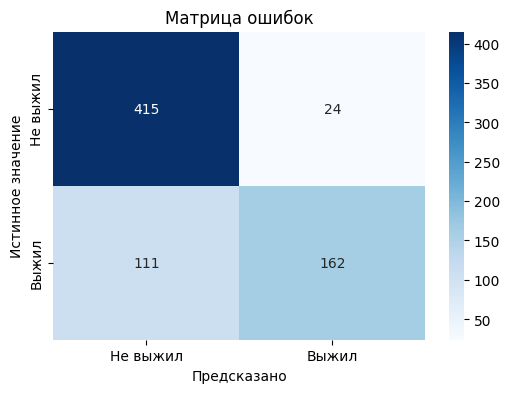

True Negative (TN): 415
False Positive (FP): 24
False Negative (FN): 111
True Positive (TP): 162


In [90]:
# Получаем матрицу ошибок
cm = confusion_matrix(y_train, y_pred_class)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Не выжил', 'Выжил'], yticklabels=['Не выжил', 'Выжил'])
plt.xlabel('Предсказано')
plt.ylabel('Истинное значение')
plt.title('Матрица ошибок')
plt.show()

print(f"True Negative (TN): {cm[0, 0]}")
print(f"False Positive (FP): {cm[0, 1]}")
print(f"False Negative (FN): {cm[1, 0]}")
print(f"True Positive (TP): {cm[1, 1]}")

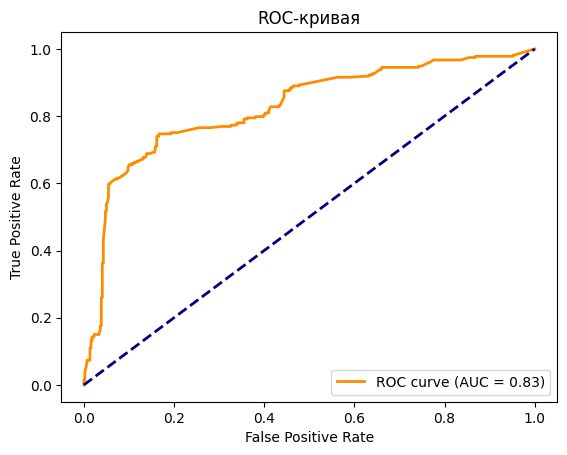

In [91]:
# Получаем FPR, TPR и пороги
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)

# Вычисляем AUC (площадь под кривой)
roc_auc = auc(fpr, tpr)

# Визуализация
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

#### Предсказание на тестовых данных

In [43]:
# 1. Преобразуем тестовые данные
X_test_transformed = preprocessor.transform(test)

# 2. Делаем предсказание на основе преобразованных данных
y_pred_test = best_model.predict(X_test_transformed)

# 3. Создаем файл для отправки
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': y_pred_test
})

# 4. Сохраняем в CSV
submission.to_csv('data/submission.csv', index=False)